In this notebook we generate some two-screen models and add an RMSF from Jack's data.

In [95]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [52]:
phi_samp, rmsf = numpy.loadtxt('rmsf.txt', dtype=complex).T
rmsf = rmsf[500:-500]

In [81]:
N = 10000
phi_channels = 1000
phis = numpy.linspace(-1000, 1000, phi_channels)
depths = numpy.random.uniform(-800, 800, size=(N, 2))
depth_indices = numpy.searchsorted(phis, depths)
phases = numpy.random.uniform(-numpy.pi, numpy.pi, size=(N, 2))
amps = numpy.random.uniform(0.0005, 0.0020, size=(N, 2))

In [82]:
spectra = numpy.zeros(shape=(N, len(phis)), dtype='complex')
for i in range(N):
    spectra[i, depth_indices[i]] += (amps[i] * (
        numpy.cos(phases[i]) + 1j * numpy.sin(phases[i])))

In [137]:
# Add a little noise.
noisy_spectra = numpy.zeros_like(spectra)
for i in range(N):
    noise = numpy.random.normal(scale=1e-5, size=spectra[i].shape)
    noise = noise + 1j * numpy.random.normal(
        scale=5e-5, size=spectra[i].shape)
    noisy_spectra[i] = noise + spectra[i]

# ...and convolve with a Gaussian to get the targets.
sigma = 20  # rad m^-2
gaussian = numpy.exp(-(phis) ** 2 / (2 * sigma ** 2)
                    ) / numpy.sqrt(2 * numpy.pi * sigma ** 2)
gaussian = gaussian + 1j * gaussian
gaussian_spectra = numpy.zeros_like(spectra)
for i in range(N):
    gaussian_spectra[i] = numpy.convolve(
        spectra[i], gaussian)[500:-499]

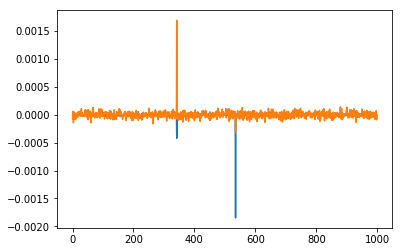

In [138]:
plt.plot(noisy_spectra[0].real)
plt.plot(noisy_spectra[0].imag)

In [139]:
# Convolve the RMSF.
obs_spectra = numpy.zeros_like(spectra)
for i in range(N):
    obs_spectra[i] = numpy.convolve(
        noisy_spectra[i], rmsf)[499:-500]

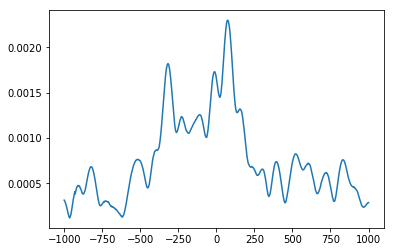

In [140]:
plt.plot(phis, abs(obs_spectra[0]))

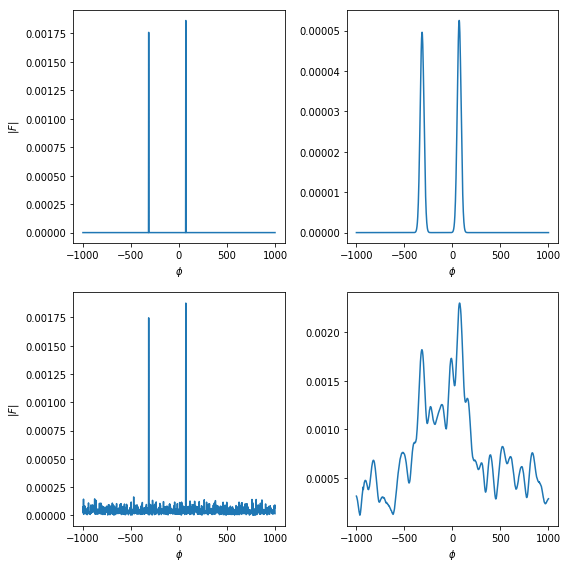

In [147]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(8, 8))
a.plot(phis, abs(spectra[0]))
b.plot(phis, abs(gaussian_spectra[0]))
c.plot(phis, abs(noisy_spectra[0]))
d.plot(phis, abs(obs_spectra[0]))
a.set_ylabel('$|F|$')
a.set_xlabel('$\\phi$')
b.set_xlabel('$\\phi$')
c.set_ylabel('$|F|$')
c.set_xlabel('$\\phi$')
d.set_xlabel('$\\phi$')
plt.tight_layout()
plt.savefig('simulated-screens.pdf')

In [145]:
numpy.save('simulated-spectra.npy', obs_spectra)
numpy.save('simulated-depths.npy', depths)
numpy.save('simulated-phases.npy', phases)
numpy.save('simulated-spectra-gt.npy', gaussian_spectra)